# El Club de la Sonrisa

Has estado estudiando y aprendiendo sobre deep learning y computer vision durante un buen tiempo ya. Una de las consecuencias de las innumerables horas que le has dedicado a tu edicación, aparte de cosechar una enorme, masculina y espartana barba, es que te has empezado a sentir un poco solo.

Por lo tanto, decides llamar a un par de amigos para planificar un viaje.

Sin embargo, no quieres lidiar con caras largas o frentes fruncidas en tu viaje. Por dicha razón, acudes a tu conocimiento recién adquirido para sólo permitir que los más felices y contentos de tus amigos te acompañen.

¿Cómo? Construyendo un detector de sonrisas, claramente.

## Preliminares

Carguemos las librerías que vamos a usar.

In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D
from keras.models import Model

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt

import helpers

%matplotlib inline

Using TensorFlow backend.


Excelente. Sigamos adelante.

## Data

Dado que reunir fotos de gente de Facebook es un poco extraño y extenuante, usemos [este conjunto de datos público](https://data.mendeley.com/datasets/yz4v8tb3tp/5) para construir nuestro modelo.

In [2]:
source = '/floyd/input/lfwcrop_color'
X_train, y_train, X_valid, y_valid, X_test, y_test = helpers.load_dataset(source)

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Imprimamos algunas estadísticas:

In [3]:
print(f'Number of training examples: {len(X_train)}')
print(f'Number of validation examples: {len(X_valid)}')
print(f'Number of test examples: {len(X_test)}')

Number of training examples: 865
Number of validation examples: 97
Number of test examples: 241


Ahora, visualicemos algunas de las imágenes.

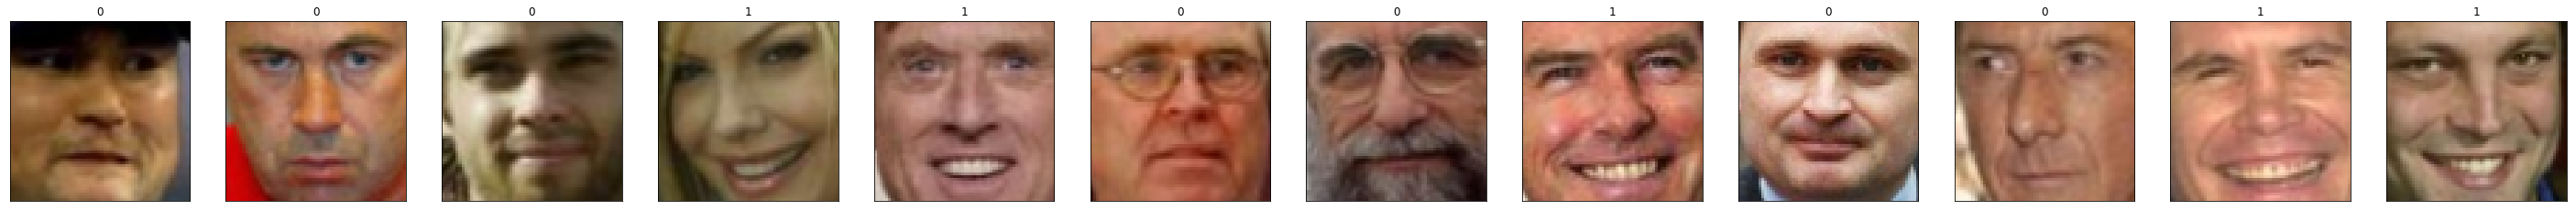

In [4]:
SAMPLE_SIZE = 12

# Plot the images in the sample
figure = plt.figure(figsize=(50, 50))

for sample_index in range(SAMPLE_SIZE):
    ax = figure.add_subplot(1, SAMPLE_SIZE, sample_index + 1, xticks=[], yticks=[])
    ax.imshow(X_train[sample_index])
    ax.set_title(y_train[sample_index])

Acá 1 representa "sonrisa", mientras que 0 representa "no sonrisa".

## El Modelo Feliz

Procedamos a construir un modelo en Keras para detectar si una persona está sonriendo o no. Considerando que sonreír tiende a ser un rasgo de la felicidad, bautizaremos nuestro algoritmo como El Modelo Feliz:

In [5]:
def happy_model(input_shape):
    X_input = Input(input_shape)
       
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides=(1, 1), name='conv0')(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Create model
    return Model(inputs = X_input, outputs = X, name='happy_model')

In [6]:
model = happy_model(input_shape=X_train[0].shape)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 70, 70, 3)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 64, 64, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 64, 64, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
__________

Afortunadamente, nuestro modelo no es tan grande. Esto es bueno puesto que requerirá menos tiempo para entrenarse.

## Entrenando el Modelo

Ahora entrenemos el modelo usando nuestra data.

Primero, debemos compilarlo:

In [7]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Fíjate que usamos adam como optimizador. Es una gran opción por defecto. Otras alternativas son SGD y Adagrad, pero adam tiende a funcionar bastante bien la mayor parte del tiempo. 

Ahora podemos entrenar el modelo.

Train on 865 samples, validate on 97 samples
Epoch 1/35
865/865 [==============================] - 48s 55ms/step - loss: 1.6622 - acc: 0.5688 - val_loss: 1.1279 - val_acc: 0.6495
Epoch 2/35
865/865 [==============================] - 0s 293us/step - loss: 0.3451 - acc: 0.8532 - val_loss: 0.2146 - val_acc: 0.9175
Epoch 3/35
865/865 [==============================] - 0s 299us/step - loss: 0.1897 - acc: 0.9272 - val_loss: 0.2387 - val_acc: 0.8763
Epoch 4/35
865/865 [==============================] - 0s 295us/step - loss: 0.1466 - acc: 0.9514 - val_loss: 0.2173 - val_acc: 0.8866
Epoch 5/35
865/865 [==============================] - 0s 300us/step - loss: 0.1140 - acc: 0.9630 - val_loss: 0.4607 - val_acc: 0.7835
Epoch 6/35
865/865 [==============================] - 0s 302us/step - loss: 0.0852 - acc: 0.9815 - val_loss: 0.1606 - val_acc: 0.9588
Epoch 7/35
865/865 [==============================] - 0s 301us/step - loss: 0.0854 - acc: 0.9792 - val_loss: 0.9317 - val_acc: 0.6907
Epoch 8/35
865/86

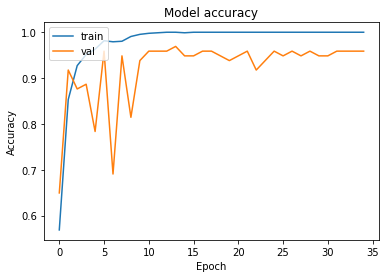

In [8]:
EPOCHS = 35
BATCH_SIZE=64

history = model.fit(X_train, y_train, 
                    validation_data=(X_valid, y_valid),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Dado que entrenamos nuestro modelo por tantos epochs, es probable que hayamos incurrido en overfitting.

## Evaluando el Modelo

Esta es la prueba real. Veamos cómo le va con data nueva.

In [9]:
predictions = model.evaluate(X_test, y_test)

print(f'Loss: {predictions[0]}')
print(f'Test Accuracy: {predictions[1]}')

241/241 [==============================] - 0s 247us/step
Loss: 0.17444497437305223
Test Accuracy: 0.941908713692946


De hecho, ¡lo hace bastante bien!

Ahora sólo necesitas conectarlo a una cámara en frente de tu casa, para desbloquear la puerta sólo cuando el modelo detecte una gran sonrisa ;)